# Coin Seminar Plant Sleep Quality Classification

## Preparation

First of all the required packages need to be installed.

In [1]:
!pip install timm librosa torch torchvision tqdm torcheval cjm_pytorch_utils

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.9 MB/s eta 0:00:00


Afterwards we will import all the required packages.

In [2]:
import random
import math
import multiprocessing
from pathlib import Path
import json

import pandas as pd
import numpy as np
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

from PIL import Image
import torchaudio
from transformers import ASTFeatureExtractor

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, LambdaLR
import torch.optim as optim

from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torcheval.metrics import R2Score, MulticlassAccuracy
from cjm_pytorch_utils.core import  get_torch_device
from tqdm.notebook import tqdm
from google.colab import drive

In [3]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [4]:
# Move model to GPU if available
device = get_torch_device()

We will then select the directory, where all plant recordings and labels are saved.

In [5]:
%cd /kaggle/input/coin-data/COIN Projekt

/kaggle/input/coin-data/COIN Projekt


### Helper functions

We will use the following helper function to load and preprocess the audio data. The function will create a tuple of arrays containing the Mel Frequency Cepstral Coefficients, the values for the MEL Spectrograms, the filenames, and the associated subset.

In [6]:
# Load and preprocess audio data
def load_and_preprocess_data(data_dir, subsets, hop_length=512, n_mels=128, n_mfcc=20, fmax = 20, n_fft = 2048):
    """Loads and preprocesses audio data from specified directories.

    Args:
      data_dir: The directory containing the audio data.
      subsets: A list of subdirectories within `data_dir` to load data from.
      hop_length: The hop length to use when computing the Mel spectrogram.
      n_mels: The number of Mel frequency bins to use.

    Returns:
      A tuple containing:
        - A list of Mel spectrograms, one for each audio file.
        - A NumPy array of filenames corresponding to the Mel spectrograms.
        - A list of MFCCs, one for each audio file.
        - A list of subset names corresponding to the Mel spectrograms.
    """
    data = []
    filenames = []
    signals = []
    subset_names = []
    audio_dir = data_dir
    # We iterate through each subset
    for i, subset in enumerate(subsets):
      subset_dir = os.path.join(audio_dir, subset)
      for filename in os.listdir(subset_dir):
        try:
          if filename.endswith('.wav'):
              file_path = os.path.join(subset_dir, filename) # joining the path to the subset and the filename to get the full path
              print(file_path)
              audio_data, sample_rate = librosa.load(file_path, sr=None) # We load the audio data with librosa
              # Perform preprocessing (e.g., convert to Mel spectrogram)
              audio_signal = np.abs(librosa.feature.mfcc(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mfcc=n_mfcc, fmax =fmax)) # Extracting Mel Frequency Cepstral Coefficients
              mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, fmax =fmax) # Extracting  Mel spectrogram
              mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # We convert the amplitudes to decibel scale
              filenames.append(filename) # Saving the filenames in case we need it later
              subset_names.append(subset)
              signals.append(audio_signal)
              data.append(mel_spectrogram)
        except:
          pass
    return data, np.array(filenames), signals, subset_names

## Loading the data

In [7]:
hop_length=256
n_mels=30
n_mfcc=40
sr = 144
n_fft= 2048
mfcc = True
fmax = 20

We will load the labels separately as a Dataframe from the sleep circle data export. It is important to note that the datetime columns "Went to bed" and "Woke up" need to be converted to the datetime with the '%Y-%m-%d %H' format.

In [8]:
sleep_circle_dir = "./data/Labels_classification/"
sleep_circle_dir

'./data/Labels_classification/'

In [9]:
sleep_circle_data_list = []
for filename in os.listdir(sleep_circle_dir):
  sleep__circle_data = pd.read_csv(os.path.join(sleep_circle_dir, filename), delimiter= ";")
  sleep__circle_data.rename(columns={"Start": "Went to bed", "End": "Woke up"}, inplace = True)
  sleep__circle_data["Went to bed"] = pd.to_datetime(sleep__circle_data["Went to bed"], format='%d.%m.%Y %H:%M')
  sleep__circle_data["Woke up"] = pd.to_datetime(sleep__circle_data["Woke up"], format='%d.%m.%Y %H:%M')
  sleep__circle_data["subset_name"] = filename.split(".csv")[0]
  sleep_circle_data_list.append(sleep__circle_data)
sleep_circle_df = pd.concat(sleep_circle_data_list)
sleep_circle_df

,subset_name,Went to bed,Woke up,ID,phase_worst
0,Jasper,2024-10-14 23:55:00,2024-10-15 07:31:00,1,0
1,Jasper,2024-10-14 23:55:00,2024-10-15 07:31:00,2,1
2,Jasper,2024-10-14 23:55:00,2024-10-15 07:31:00,3,1
3,Jasper,2024-10-14 23:55:00,2024-10-15 07:31:00,4,2
4,Jasper,2024-10-14 23:55:00,2024-10-15 07:31:00,5,2
...,...,...,...,...,...
316,Fynn,2024-12-13 23:39:00,2024-12-14 07:00:00,5,2
317,Fynn,2024-12-13 23:39:00,2024-12-14 07:00:00,6,2
318,Fynn,2024-12-13 23:39:00,2024-12-14 07:00:00,7,0
319,Fynn,2024-12-13 23:39:00,2024-12-14 07:00:00,8,2


In [10]:
sleep_circle_df["subset_name"].unique()

array(['Jasper', 'behrad', 'linus', 'Fynn'], dtype=object)

With the helper function we will load and preprocess the plant recordings.

In [11]:
data_dir = './data/Audio_Data'
subsets = ['behrad', 'linus', 'Jasper', 'Fynn']
audio_files, filenames, signals, subset_names  = load_and_preprocess_data(data_dir = data_dir, subsets = subsets, hop_length=hop_length, n_mels=n_mels, n_mfcc=n_mfcc, fmax = fmax, n_fft= n_fft)

./data/Audio_Data/behrad/behrad_142Hz_1729904937567.wav
./data/Audio_Data/behrad/behrad_142Hz_1731290866877.wav
./data/Audio_Data/behrad/behrad_142Hz_1730861279308.wav
./data/Audio_Data/behrad/behrad_142Hz_1734063115337.wav
./data/Audio_Data/behrad/behrad_142Hz_1729820420488.wav
./data/Audio_Data/behrad/behrad_142Hz_1731894532622.wav
./data/Audio_Data/behrad/behrad_142Hz_1736132158020.wav
./data/Audio_Data/behrad/behrad_142Hz_1730341004221.wav
./data/Audio_Data/behrad/behrad_142Hz_1731205560774.wav
./data/Audio_Data/behrad/behrad_142Hz_1736046241399.wav
./data/Audio_Data/behrad/behrad_142Hz_1730169214846.wav
./data/Audio_Data/behrad/behrad_142Hz_1731375736354.wav
./data/Audio_Data/behrad/behrad_142Hz_1730426561089.wav
./data/Audio_Data/behrad/behrad_142Hz_1731552619742.wav
./data/Audio_Data/behrad/behrad_142Hz_1729733764243.wav
./data/Audio_Data/behrad/behrad_142Hz_1731463744547.wav
./data/Audio_Data/behrad/behrad_142Hz_1731639615572.wav
./data/Audio_Data/behrad/behrad_142Hz_1729994749

From the filenames we extract the timestamp and convert it to the same format as the "Went to bed" column from the sleep circle data.

In [12]:
audio_timestamps = []
for filename in filenames:
  timestamp = filename.split("_")[-1]
  timestamp = timestamp.split(".")[0]
  timestamp = int(timestamp)
  timestamp = datetime.utcfromtimestamp(timestamp/1000).strftime('%Y-%m-%d %H:%M')
  audio_timestamps.append(timestamp)

We join the arrays to a single dataframe for easier use.

In [13]:
audio_df = pd.DataFrame(data = {"timestamp": audio_timestamps, "mel_spectrogram": audio_files, "mfcc": signals, "filenames": filenames, "subset": subset_names})
audio_df['timestamp'] = pd.to_datetime(audio_df['timestamp'])
audio_df

,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-26 01:08:00,"[[-9.2420845, -8.9146, -9.977047, -11.0775795,...","[[6.19677, 8.87266, 59.520477, 163.0446, 231.6...",behrad_142Hz_1729904937567.wav,behrad
1,2024-11-11 02:07:00,"[[-0.31482506, -0.015159607, -1.1237984, -2.26...","[[22.55347, 7.3790236, 43.656452, 148.03131, 2...",behrad_142Hz_1731290866877.wav,behrad
2,2024-11-06 02:47:00,"[[-0.45116806, -0.16116333, -1.3247013, -2.558...","[[22.491035, 7.4850225, 42.806576, 141.86917, ...",behrad_142Hz_1730861279308.wav,behrad
3,2024-12-13 04:11:00,"[[-0.25584793, 1.9073486e-06, -1.2094803, -2.4...","[[18.20495, 2.9546754, 48.079334, 151.05196, 2...",behrad_142Hz_1734063115337.wav,behrad
4,2024-10-25 01:40:00,"[[-16.613756, -15.924599, -16.235882, -16.4384...","[[26.26631, 11.896808, 35.06353, 116.698326, 1...",behrad_142Hz_1729820420488.wav,behrad
...,...,...,...,...,...
105,2024-10-27 22:55:00,"[[-18.617352, -18.092136, -18.559153, -18.8898...","[[22.441267, 8.982217, 33.520874, 92.850815, 1...",fynn_142Hz_1730069702973.wav,Fynn
106,2024-10-23 21:16:00,"[[-18.906769, -18.390114, -19.519203, -21.3323...","[[39.473507, 24.51605, 25.947687, 128.03618, 9...",fynn_142Hz_1729718185899.wav,Fynn
107,2024-10-29 22:24:00,"[[-0.3615055, -0.07218933, -1.238081, -2.46934...","[[31.007368, 15.881582, 35.165386, 144.34479, ...",fynn_142Hz_1730240668606.wav,Fynn
108,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn


We will sort the sleep circle data and the plant recording data to merge both dataframe with eachother.

In [14]:
sleep_circle_df = sleep_circle_df.sort_values("Went to bed")

audio_df = audio_df.sort_values('timestamp')

Because the plant recording starting time and the sleep circle timestamp sometimes do not match to the exact hour, we will merge both dataframes on the "Went to bed" column and the "timestamp" column with a range of 3 hours.

In [15]:
concat_arr = []
for subset in subsets:
  subset_df = audio_df[audio_df["subset"] == subset]
  sleep_circle_subset_df = sleep_circle_df[sleep_circle_df["subset_name"] == subset]
  subset_merged_df = pd.merge_asof(sleep_circle_subset_df, subset_df, left_on="Went to bed", right_on ="timestamp", direction='nearest', tolerance=pd.Timedelta('3 hour'))
  concat_arr.append(subset_merged_df)
merged_df = pd.concat(concat_arr)

We drop all rows which have null values for the mel_spectrogram. Furthermore we convert the sleep quality column to the float data type ranging from 0 to 1.

In [16]:
merged_df = merged_df.dropna(subset = ["mel_spectrogram"]).reset_index(drop=True)
#merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", ""))/100)
#merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", "")))
merged_df

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset
0,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,4,2,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
1,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,8,0,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
2,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,7,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
3,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,6,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
4,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,5,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
...,...,...,...,...,...,...,...,...,...,...
807,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,4,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn
808,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,2,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn
809,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,1,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn
810,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,6,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn


In [17]:
merged_df[merged_df["subset"]== "behrad"]

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset
0,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,4,2,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
1,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,8,0,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
2,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,7,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
3,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,6,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
4,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,5,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad
...,...,...,...,...,...,...,...,...,...,...
182,behrad,2024-12-13 05:12:00,2024-12-13 10:04:00,1,0,2024-12-13 04:11:00,"[[-0.25584793, 1.9073486e-06, -1.2094803, -2.4...","[[18.20495, 2.9546754, 48.079334, 151.05196, 2...",behrad_142Hz_1734063115337.wav,behrad
183,behrad,2024-12-13 05:12:00,2024-12-13 10:04:00,2,0,2024-12-13 04:11:00,"[[-0.25584793, 1.9073486e-06, -1.2094803, -2.4...","[[18.20495, 2.9546754, 48.079334, 151.05196, 2...",behrad_142Hz_1734063115337.wav,behrad
184,behrad,2024-12-13 05:12:00,2024-12-13 10:04:00,3,0,2024-12-13 04:11:00,"[[-0.25584793, 1.9073486e-06, -1.2094803, -2.4...","[[18.20495, 2.9546754, 48.079334, 151.05196, 2...",behrad_142Hz_1734063115337.wav,behrad
185,behrad,2024-12-13 05:12:00,2024-12-13 10:04:00,4,2,2024-12-13 04:11:00,"[[-0.25584793, 1.9073486e-06, -1.2094803, -2.4...","[[18.20495, 2.9546754, 48.079334, 151.05196, 2...",behrad_142Hz_1734063115337.wav,behrad


In [18]:
merged_df[merged_df["subset"]== "linus"]

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset
187,linus,2024-10-24 00:16:00,2024-10-24 08:11:00,8,1,2024-10-23 22:16:00,"[[-0.27054596, 0.0, -1.1743965, -2.383419, -2....","[[25.312414, 10.344823, 39.466778, 137.9622, 2...",linus_142Hz_1729721787072.wav,linus
188,linus,2024-10-24 00:16:00,2024-10-24 08:11:00,7,1,2024-10-23 22:16:00,"[[-0.27054596, 0.0, -1.1743965, -2.383419, -2....","[[25.312414, 10.344823, 39.466778, 137.9622, 2...",linus_142Hz_1729721787072.wav,linus
189,linus,2024-10-24 00:16:00,2024-10-24 08:11:00,9,0,2024-10-23 22:16:00,"[[-0.27054596, 0.0, -1.1743965, -2.383419, -2....","[[25.312414, 10.344823, 39.466778, 137.9622, 2...",linus_142Hz_1729721787072.wav,linus
190,linus,2024-10-24 00:16:00,2024-10-24 08:11:00,6,1,2024-10-23 22:16:00,"[[-0.27054596, 0.0, -1.1743965, -2.383419, -2....","[[25.312414, 10.344823, 39.466778, 137.9622, 2...",linus_142Hz_1729721787072.wav,linus
191,linus,2024-10-24 00:16:00,2024-10-24 08:11:00,5,0,2024-10-23 22:16:00,"[[-0.27054596, 0.0, -1.1743965, -2.383419, -2....","[[25.312414, 10.344823, 39.466778, 137.9622, 2...",linus_142Hz_1729721787072.wav,linus
...,...,...,...,...,...,...,...,...,...,...
495,linus,2024-12-16 01:10:00,2024-12-16 08:04:00,3,2,2024-12-16 00:04:00,"[[-4.5009403, -3.3664265, -3.138506, -3.589367...","[[112.370895, 117.86067, 139.93248, 161.76938,...",linus_142Hz_1734307486967.wav,linus
496,linus,2024-12-16 01:10:00,2024-12-16 08:04:00,2,2,2024-12-16 00:04:00,"[[-4.5009403, -3.3664265, -3.138506, -3.589367...","[[112.370895, 117.86067, 139.93248, 161.76938,...",linus_142Hz_1734307486967.wav,linus
497,linus,2024-12-16 01:10:00,2024-12-16 08:04:00,1,0,2024-12-16 00:04:00,"[[-4.5009403, -3.3664265, -3.138506, -3.589367...","[[112.370895, 117.86067, 139.93248, 161.76938,...",linus_142Hz_1734307486967.wav,linus
498,linus,2024-12-16 01:10:00,2024-12-16 08:04:00,7,2,2024-12-16 00:04:00,"[[-4.5009403, -3.3664265, -3.138506, -3.589367...","[[112.370895, 117.86067, 139.93248, 161.76938,...",linus_142Hz_1734307486967.wav,linus


In [19]:
merged_df["max_id"] = merged_df.groupby(["subset", "Went to bed", "Woke up"])["ID"].transform("max")

In [20]:
def split_mfcc(x, mfcc = True):

  # Calculate the time per frame
  time_per_frame = hop_length / sr
  # Calculate frames per hour and frames to adjust by split_minutes
  frames_per_hour = int((60 * 60) / time_per_frame)  # 1 hour in seconds
  split_minutes_start = x["Went to bed"].minute  # Adjust the first and last part by these many minutes
  split_minutes_end = x["Woke up"].minute
  frames_split_adjust_start = int((split_minutes_start * 60) / time_per_frame)  # split_minutes to seconds
  frames_split_adjust_end = int((split_minutes_end * 60) / time_per_frame)  # split_minutes to seconds

  # Total number of frames
  if mfcc:
    total_frames = x["mfcc"].shape[1]
  else:
    total_frames = x["mel_spectrogram"].shape[1]

  # Split the MFCC into hourly parts with adjusted first and last segments
  hourly_parts = []
  start_frame = 0
  edge_case = False
  while start_frame < total_frames:
      # Determine end_frame for this segment
      if start_frame == 0:
          # Adjust the first segment by split_minutes
          end_frame = start_frame + frames_per_hour - frames_split_adjust_start
          edge_case = True
      elif start_frame + frames_per_hour >= total_frames:
          # Adjust the last segment by split_minutes
          end_frame = total_frames
          start_frame = max(0, start_frame + frames_split_adjust_end)
          edge_case = True
          #start_frame = max(0, total_frames - frames_split_adjust_end)  # Remove frames_split_adjust from the start
      else:
          # Regular hourly split
          end_frame = start_frame + frames_per_hour

      # Extract this part and add to the list
      if edge_case == False:
        if mfcc:
          hourly_parts.append(x["mfcc"][:, start_frame:end_frame])
        else:
          hourly_parts.append(x["mel_spectrogram"][:, start_frame:end_frame])
      else:
        edge_case = False
      start_frame = end_frame
  if (x["ID"] > len(hourly_parts)):
    return []
  else:
    return hourly_parts[x["ID"]-1]

In [21]:
merged_df["split_audio"] = merged_df.apply(lambda x: split_mfcc(x, mfcc= mfcc), axis = 1)

In [22]:
merged_df

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset,max_id,split_audio
0,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,4,2,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[158.74289, 167.85217, 182.79573, 188.66942, ..."
1,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,8,0,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,[]
2,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,7,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[166.86345, 160.9071, 157.15079, 151.7337, 15..."
3,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,6,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[190.35956, 189.52705, 185.08545, 182.6473, 1..."
4,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,5,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[165.67648, 175.33943, 178.05719, 179.18552, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
807,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,4,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[253.2885, 252.53714, 252.73674, 255.43935, 2..."
808,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,2,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[258.34534, 248.11269, 245.7157, 246.70569, 2..."
809,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,1,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[257.30164, 256.34045, 255.17172, 254.67978, ..."
810,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,6,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[240.09567, 236.72806, 228.51079, 224.25047, ..."


In [23]:
merged_df[(merged_df["ID"] == merged_df["max_id"])]

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset,max_id,split_audio
8,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,9,0,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,[]
9,behrad,2024-10-26 03:12:00,2024-10-26 10:39:00,8,0,2024-10-26 01:08:00,"[[-9.2420845, -8.9146, -9.977047, -11.0775795,...","[[6.19677, 8.87266, 59.520477, 163.0446, 231.6...",behrad_142Hz_1729904937567.wav,behrad,8,[]
17,behrad,2024-10-27 03:06:00,2024-10-27 11:29:00,9,0,2024-10-27 02:05:00,"[[-18.439304, -18.09485, -19.283329, -20.81222...","[[30.924953, 15.7010565, 35.603226, 143.04831,...",behrad_142Hz_1729994749595.wav,behrad,9,[]
28,behrad,2024-10-29 03:34:00,2024-10-29 11:30:00,9,0,2024-10-29 02:33:00,"[[-19.055973, -18.70649, -19.736286, -20.82465...","[[17.115925, 2.0292037, 48.537975, 150.95795, ...",behrad_142Hz_1730169214846.wav,behrad,9,[]
37,behrad,2024-10-31 03:20:00,2024-10-31 10:36:00,8,0,2024-10-31 02:16:00,"[[-19.71548, -19.180487, -20.089596, -21.05535...","[[5.001769, 12.224515, 39.954525, 72.365585, 7...",behrad_142Hz_1730341004221.wav,behrad,8,[]
...,...,...,...,...,...,...,...,...,...,...,...,...
768,Fynn,2024-11-18 23:17:00,2024-11-19 07:31:00,9,0,2024-11-18 22:14:00,"[[-0.3509407, -0.057617188, -1.201416, -2.3909...","[[31.059774, 15.9857855, 34.831978, 141.67262,...",fynn_142Hz_1731968098508.wav,Fynn,9,[]
779,Fynn,2024-11-19 23:51:00,2024-11-20 08:12:00,10,0,2024-11-19 22:46:00,"[[-0.5027447, -0.2095604, -1.3576012, -2.55023...","[[31.770903, 16.68067, 34.12682, 140.71599, 24...",fynn_142Hz_1732056377456.wav,Fynn,10,[]
787,Fynn,2024-11-20 23:51:00,2024-11-21 08:30:00,10,0,2024-11-20 22:51:00,"[[-2.207796, -1.9584122, -3.1639862, -4.390079...","[[33.47163, 18.879385, 30.19658, 123.80778, 11...",fynn_142Hz_1732143060447.wav,Fynn,10,[]
800,Fynn,2024-11-21 23:27:00,2024-11-22 08:06:00,10,0,2024-11-21 22:27:00,"[[-0.46880722, -0.17958069, -1.3373146, -2.544...","[[30.774675, 15.764097, 35.16172, 145.54292, 2...",fynn_142Hz_1732228030045.wav,Fynn,10,[]


In [24]:
#merged_df = merged_df[merged_df["Went to bed"]<= "2024-12-01"].reset_index(drop=True)
merged_df

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset,max_id,split_audio
0,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,4,2,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[158.74289, 167.85217, 182.79573, 188.66942, ..."
1,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,8,0,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,[]
2,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,7,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[166.86345, 160.9071, 157.15079, 151.7337, 15..."
3,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,6,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[190.35956, 189.52705, 185.08545, 182.6473, 1..."
4,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,5,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[165.67648, 175.33943, 178.05719, 179.18552, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
807,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,4,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[253.2885, 252.53714, 252.73674, 255.43935, 2..."
808,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,2,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[258.34534, 248.11269, 245.7157, 246.70569, 2..."
809,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,1,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[257.30164, 256.34045, 255.17172, 254.67978, ..."
810,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,6,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[240.09567, 236.72806, 228.51079, 224.25047, ..."


In [25]:
merged_df = merged_df[merged_df["split_audio"].apply(lambda x: len(x) > 0) ]
merged_df = merged_df[merged_df["split_audio"].apply(lambda x: x.shape[1] != 0) ]
merged_df.reset_index(drop=True, inplace=True)

In [26]:
merged_df.groupby("phase_worst").count()/len(merged_df)

,subset_name,Went to bed,Woke up,ID,timestamp,mel_spectrogram,mfcc,filenames,subset,max_id,split_audio
phase_worst,,,,,,,,,,,
0,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269
1,0.304954,0.304954,0.304954,0.304954,0.304954,0.304954,0.304954,0.304954,0.304954,0.304954,0.304954
2,0.363777,0.363777,0.363777,0.363777,0.363777,0.363777,0.363777,0.363777,0.363777,0.363777,0.363777


In [27]:
merged_df["sleeping"] = merged_df["phase_worst"].apply(lambda x: 1 if x > 0 else 0)

In [28]:
merged_df.groupby("sleeping").count()/len(merged_df)

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset,max_id,split_audio
sleeping,,,,,,,,,,,,
0,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269,0.331269
1,0.668731,0.668731,0.668731,0.668731,0.668731,0.668731,0.668731,0.668731,0.668731,0.668731,0.668731,0.668731


In [29]:
merged_df

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset,max_id,split_audio,sleeping
0,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,4,2,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[158.74289, 167.85217, 182.79573, 188.66942, ...",1
1,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,7,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[166.86345, 160.9071, 157.15079, 151.7337, 15...",1
2,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,6,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[190.35956, 189.52705, 185.08545, 182.6473, 1...",1
3,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,5,1,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[165.67648, 175.33943, 178.05719, 179.18552, ...",1
4,behrad,2024-10-24 03:37:00,2024-10-24 11:30:00,3,2,2024-10-24 01:36:00,"[[-19.405912, -18.915133, -19.748577, -20.6414...","[[5.601686, 9.220065, 58.546867, 150.96732, 18...",behrad_142Hz_1729733764243.wav,behrad,9,"[[112.28847, 110.32197, 78.112595, 51.346596, ...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
641,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,4,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[253.2885, 252.53714, 252.73674, 255.43935, 2...",1
642,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,2,1,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[258.34534, 248.11269, 245.7157, 246.70569, 2...",1
643,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,1,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[257.30164, 256.34045, 255.17172, 254.67978, ...",0
644,Fynn,2024-11-24 23:31:00,2024-11-25 08:07:00,6,0,2024-11-24 22:26:00,"[[-0.30607033, -0.006788254, -1.1527157, -2.35...","[[31.142927, 16.200102, 34.127357, 139.34103, ...",fynn_142Hz_1732487181377.wav,Fynn,10,"[[240.09567, 236.72806, 228.51079, 224.25047, ...",0


## Visualizing the data

In [30]:
merged_df["mel_spectrogram"][0].shape

(30, 15808)

In [31]:
merged_df["mel_spectrogram"][0]

array([[-19.405912, -18.915133, -19.748577, ..., -19.374779, -17.6831  ,
        -16.480696],
       [-31.324924, -32.6532  , -36.969296, ..., -40.118027, -32.056175,
        -28.41421 ],
       [-35.1559  , -36.48987 , -40.800495, ..., -44.085705, -36.156715,
        -32.538376],
       ...,
       [-53.958168, -55.27647 , -59.770386, ..., -63.29457 , -55.215103,
        -51.622627],
       [-54.76493 , -56.109474, -60.61621 , ..., -63.491676, -55.494217,
        -51.92843 ],
       [-55.267136, -56.467987, -60.169186, ..., -61.834568, -56.024437,
        -52.779854]], dtype=float32)

In [32]:
np.abs(merged_df["mfcc"][0])

array([[ 5.601686  ,  9.220065  , 58.546867  , ..., 90.52051   ,
         5.3107624 , 33.672146  ],
       [79.3391    , 79.437065  , 79.31755   , ..., 77.188324  ,
        78.30016   , 79.1697    ],
       [29.10128   , 29.620296  , 31.140663  , ..., 36.36914   ,
        32.729332  , 31.365582  ],
       ...,
       [ 1.4882014 ,  1.7868109 ,  2.4119635 , ...,  0.2653082 ,
         0.6545454 ,  0.9697393 ],
       [ 1.7411983 ,  1.9933572 ,  2.029182  , ...,  2.6292107 ,
         2.1046257 ,  1.4954681 ],
       [ 1.3948096 ,  1.7512194 ,  2.575138  , ...,  1.7358742 ,
         1.0369613 ,  0.62139165]], dtype=float32)

We plot the MEL-Spectrogram and the MFCC with the librosa.display.specshow function (https://librosa.org/doc/main/generated/librosa.display.specshow.html). All values are plotted in hz units but the scale differs (MEL-Spectrogram uses mel scale while MFCC uses hz).

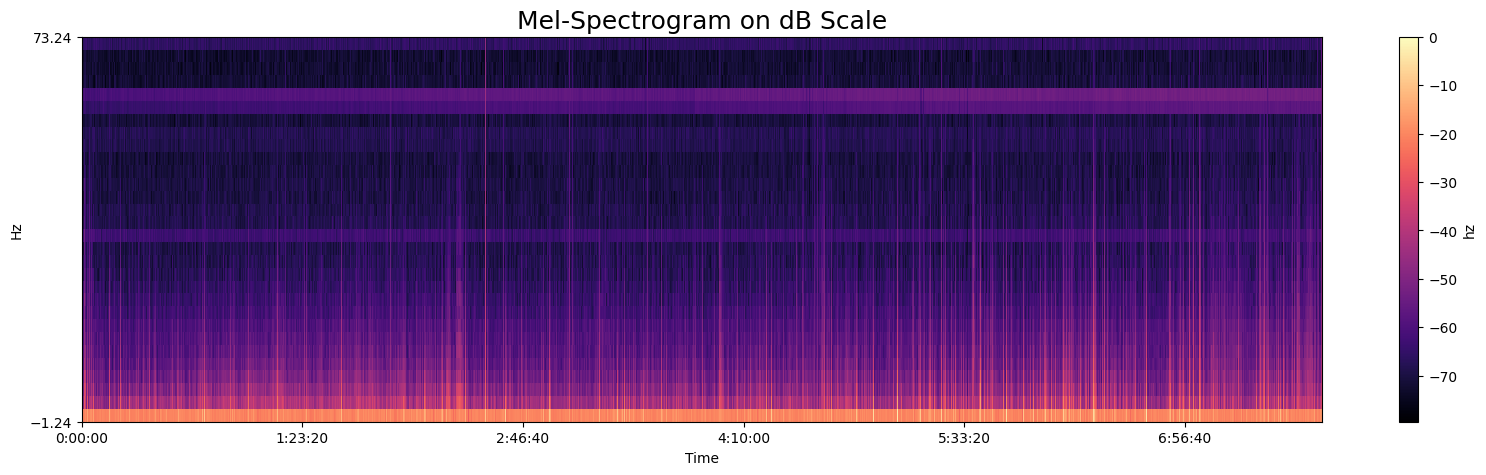

In [33]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(merged_df["mel_spectrogram"][0], x_axis='time',
                         y_axis='mel', sr=sr, cmap= "magma", hop_length=hop_length)
plt.colorbar(label="hz")
plt.title('Mel-Spectrogram on dB Scale', fontdict=dict(size=18))
plt.show()

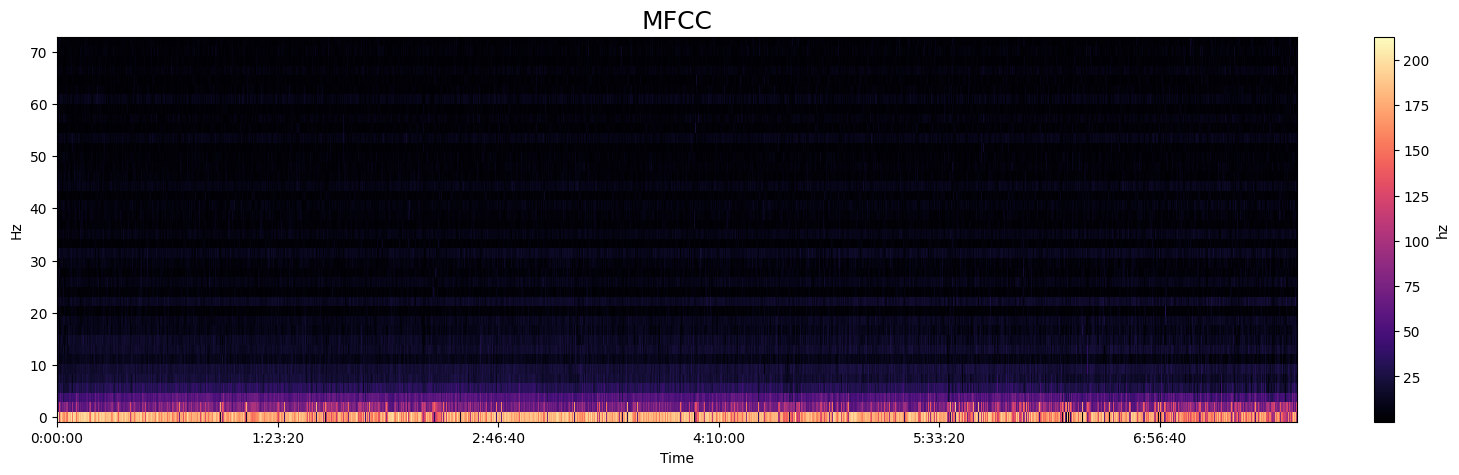

In [34]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(np.abs(merged_df["mfcc"][0]), x_axis='time',
                         y_axis = "hz", sr=sr, cmap= "magma", hop_length=hop_length)
plt.colorbar(label = "hz")
plt.title("MFCC", fontdict=dict(size=18))
plt.show()

We will also visualize the waveform to look at the peaks of amiplitudes (https://librosa.org/doc/main/generated/librosa.display.waveshow.html).

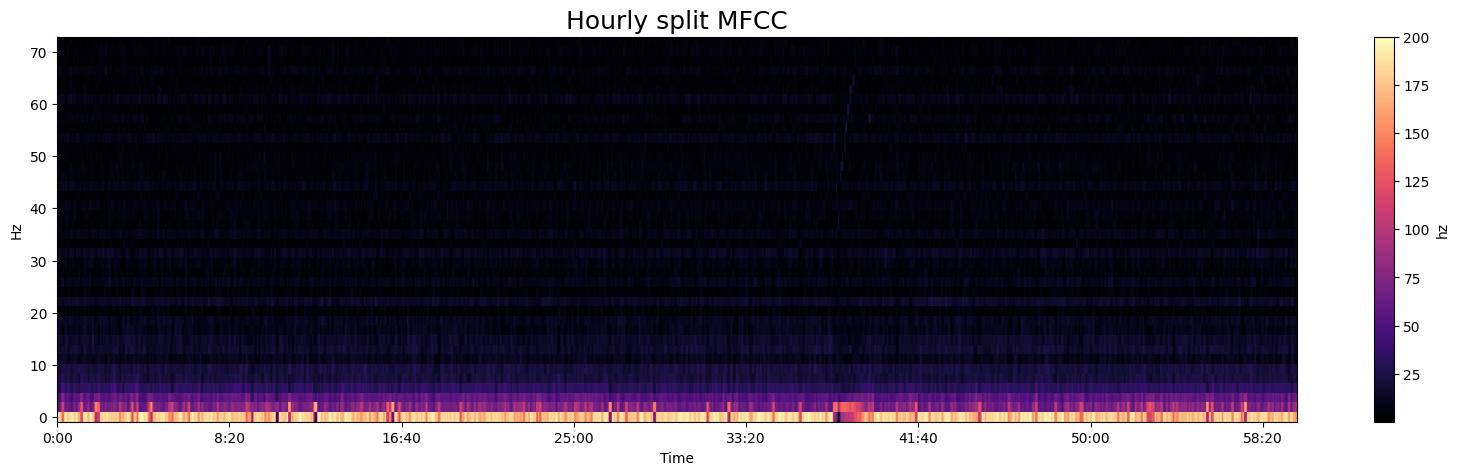

In [35]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(merged_df["split_audio"][0], x_axis='time',
                         y_axis = "hz", sr=144, cmap= "magma", hop_length=hop_length)
plt.colorbar(label = "hz")
plt.title("Hourly split MFCC", fontdict=dict(size=18))
plt.show()

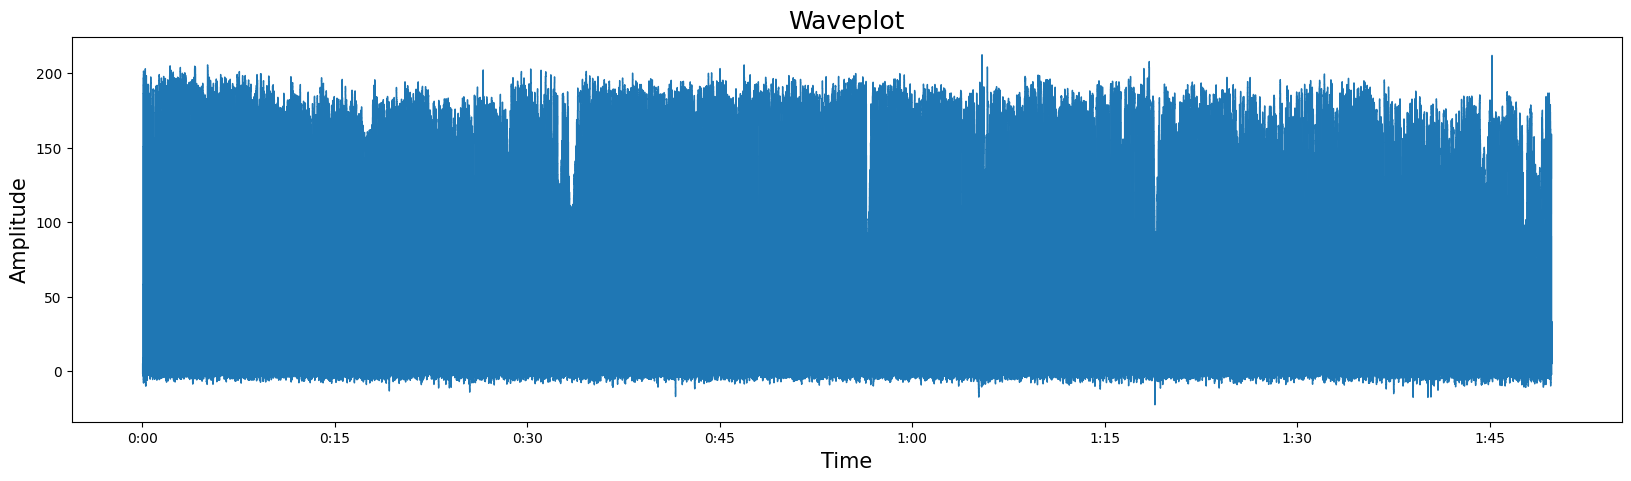

In [36]:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(merged_df["mfcc"][0], sr = 144)
plt.title("Waveplot", fontdict=dict(size=18))
plt.xlabel("Time", fontdict=dict(size=15))
plt.ylabel("Amplitude", fontdict=dict(size=15))
plt.show()

## Training Image Classification Neural Networks

## Model loading

In [37]:
# Load a pretrained model from timm

#model = timm.create_model('resnet18', pretrained=True)
model = timm.create_model("eva02_base_patch14_448.mim_in22k_ft_in22k_in1k", pretrained=True, num_classes=3)
model

model.safetensors:   0%|          | 0.00/348M [00:00<?, ?B/s]

Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-11): 12 x EvaBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=768, out_features=2048, bias=True)
        (fc1_x): Linear(in_features=76

In [38]:
model.pretrained_cfg

{'url': '',
 'hf_hub_id': 'timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k',
 'architecture': 'eva02_base_patch14_448',
 'tag': 'mim_in22k_ft_in22k_in1k',
 'custom_load': False,
 'input_size': (3, 448, 448),
 'fixed_input_size': True,
 'interpolation': 'bicubic',
 'crop_pct': 1.0,
 'crop_mode': 'squash',
 'mean': (0.48145466, 0.4578275, 0.40821073),
 'std': (0.26862954, 0.26130258, 0.27577711),
 'num_classes': 1000,
 'pool_size': None,
 'first_conv': 'patch_embed.proj',
 'classifier': 'head',
 'license': 'mit'}

### Dataset

We create a custom dataframe object for the mfcc or the melspectrogram.

In [39]:
class AudioDataset(Dataset):
    def __init__(self, audio_data, labels, transform=None):
        self.audio_data = audio_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        # Load mel spectrogram
        mel_spectrogram = np.dstack([self.audio_data[idx], self.audio_data[idx], self.audio_data[idx]])

        # Apply transforms if specified
        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)

        label = self.labels[idx]

        return mel_spectrogram, label

# Define transform to convert numpy arrays to torch tensors and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(model.pretrained_cfg["input_size"][1:]),  # Match input size expected by the model
    transforms.Normalize(mean=model.pretrained_cfg["mean"], std=model.pretrained_cfg["std"])
])

First we split the dataframe into train and validation set.

In [40]:
#merged_df

#merged_df["Sleep Quality"] = (merged_df["Sleep Quality"]- merged_df["Sleep Quality"].abs().min())/ (merged_df["Sleep Quality"].abs().max() - merged_df["Sleep Quality"].abs().min())

train_df = merged_df.sample(frac=0.8, random_state=42)
val_df = merged_df.drop(train_df.index).reset_index(drop=True)
train_df = train_df.reset_index(drop=True)
train_df

,subset_name,Went to bed,Woke up,ID,phase_worst,timestamp,mel_spectrogram,mfcc,filenames,subset,max_id,split_audio,sleeping
0,Fynn,2024-11-21 23:27:00,2024-11-22 08:06:00,5,1,2024-11-21 22:27:00,"[[-0.46880722, -0.17958069, -1.3373146, -2.544...","[[30.774675, 15.764097, 35.16172, 145.54292, 2...",fynn_142Hz_1732228030045.wav,Fynn,10,"[[233.10608, 239.47562, 255.93987, 265.51624, ...",1
1,linus,2024-12-06 00:18:00,2024-12-06 09:47:00,8,1,2024-12-05 23:19:00,"[[-8.037205, -7.8176203, -9.002817, -10.021693...","[[128.11696, 129.18314, 149.53062, 176.93135, ...",linus_142Hz_1733440767698.wav,linus,10,"[[213.29376, 210.67323, 207.54712, 204.1863, 2...",1
2,linus,2024-12-02 00:10:00,2024-12-02 08:04:00,3,2,2024-12-01 23:02:00,"[[-7.940242, -6.07934, -6.2515163, -6.9135933,...","[[122.658424, 104.22659, 108.49202, 129.8086, ...",linus_142Hz_1733094146405.wav,linus,9,"[[153.19672, 186.52556, 216.04945, 218.24039, ...",1
3,linus,2024-11-24 23:14:00,2024-11-25 08:05:00,1,0,2024-11-24 22:06:00,"[[-12.492601, -12.213652, -13.610122, -15.0349...","[[195.59676, 185.14893, 189.12761, 198.50989, ...",linus_142Hz_1732485978173.wav,linus,10,"[[222.45987, 215.72504, 180.97076, 144.68004, ...",0
4,behrad,2024-11-07 03:17:00,2024-11-07 11:30:00,7,0,2024-11-07 01:51:00,"[[-16.291348, -15.762112, -16.237541, -16.9713...","[[49.138214, 37.94248, 3.6010368, 31.201448, 4...",behrad_07-11-2024_02_51_09_142Hz_1730944269321...,behrad,9,"[[180.87686, 170.94243, 170.67282, 176.51756, ...",0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,Fynn,2024-10-30 23:12:00,2024-10-31 07:11:00,3,2,2024-10-30 22:09:00,"[[-0.29032516, 0.0, -1.1587124, -2.3706608, -2...","[[30.905085, 15.813387, 35.124966, 144.06517, ...",fynn_142Hz_1730326147804.wav,Fynn,9,"[[257.97003, 258.13055, 252.84106, 244.48834, ...",1
513,Jasper,2024-11-23 00:38:00,2024-11-23 09:56:00,7,2,2024-11-22 23:37:00,"[[-0.25543594, 0.0, -1.2171803, -2.431099, -2....","[[22.08028, 7.049459, 43.096058, 137.45941, 18...",Jasper_142Hz_1732318627907.wav,Jasper,10,"[[211.61758, 182.41214, 152.97574, 137.88544, ...",1
514,linus,2024-12-04 00:54:00,2024-12-04 09:00:00,1,0,2024-12-03 23:54:00,"[[-10.260212, -9.826486, -10.759546, -11.79960...","[[176.72241, 167.07265, 169.89194, 179.66531, ...",linus_142Hz_1733270079471.wav,linus,10,"[[187.85385, 174.7122, 158.66273, 148.27797, 1...",0
515,Fynn,2024-10-28 00:11:00,2024-10-28 07:44:00,4,1,2024-10-27 22:55:00,"[[-18.617352, -18.092136, -18.559153, -18.8898...","[[22.441267, 8.982217, 33.520874, 92.850815, 1...",fynn_142Hz_1730069702973.wav,Fynn,8,"[[225.90836, 226.38426, 224.61421, 222.95744, ...",1


In [41]:
train_df.merge(val_df, on=["filenames", "ID"], how = "inner")

,subset_name_x,Went to bed_x,Woke up_x,ID,phase_worst_x,timestamp_x,mel_spectrogram_x,mfcc_x,filenames,subset_x,...,Went to bed_y,Woke up_y,phase_worst_y,timestamp_y,mel_spectrogram_y,mfcc_y,subset_y,max_id_y,split_audio_y,sleeping_y


In [42]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()#//2
batch_size = 4
# Define parameters for DataLoader
data_loader_params = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

In [43]:
# Instantiate the dataset
dataset_train = AudioDataset(audio_data=train_df["split_audio"], labels=train_df["phase_worst"], transform=transform)
dataset_val = AudioDataset(audio_data=val_df["split_audio"], labels=val_df["phase_worst"], transform=transform)

# Create a DataLoader
data_loader = DataLoader(dataset_train, **data_loader_params, shuffle=True, drop_last=True)
data_loader_val = DataLoader(dataset_val, **data_loader_params, shuffle=False, drop_last=True)

It is important to note that we are doing a regression task, therefore we need to change the last layer to have only one output feature.

### Model training

In [44]:
model = model.to(device)

In [45]:
def get_warmup_scheduler(optimizer, num_warmup_steps, total_steps):
    """
    Returns a scheduler with a linear warmup phase.

    :param optimizer: Optimizer to adjust the learning rate for.
    :param num_warmup_steps: Number of steps for the warmup phase.
    :param total_steps: Total number of training steps.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - num_warmup_steps)))

    return LambdaLR(optimizer, lr_lambda)

In [46]:
class WarmupDecayScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, min_lr=0, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        super(WarmupDecayScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        current_step = self.last_epoch + 1
        if current_step < self.warmup_steps:
            # Warmup phase: Linear increase
            scale = current_step / self.warmup_steps
        else:
            # Decay phase: Cosine decay
            decay_steps = self.total_steps - self.warmup_steps
            scale = max(
                0,
                0.5 * (1 + math.cos(math.pi * (current_step - self.warmup_steps) / decay_steps))
            )
        return [
            self.min_lr + (base_lr - self.min_lr) * scale
            for base_lr in self.base_lrs
        ]

In [47]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, num_classes=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.num_classes = num_classes
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.ce_loss(inputs, targets)
        p_t = torch.exp(-ce_loss)  # Probabilities for the true class
        loss = self.alpha * (1 - p_t) ** self.gamma * ce_loss
        return loss.mean()

In [48]:
lr = 1e-6
epochs = 2*3

# Calculate the weights for each class
total_samples = len(merged_df)
class_weights = [total_samples / count for count in (merged_df.groupby("phase_worst").count())["ID"]]
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
#criterion = FocalLoss(alpha=0.1, gamma=4.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
metric = MulticlassAccuracy()
# Define warmup and total steps
total_steps = len(data_loader) * epochs
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio * total_steps)

# Create scheduler
#lr_scheduler = get_warmup_scheduler(optimizer, num_warmup_steps, total_steps)
lr_scheduler = WarmupDecayScheduler(optimizer, num_warmup_steps, total_steps, min_lr=5e-7)

In [49]:
#step_size = 3
#gamma = 0.5

# Scheduler
#scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [50]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, criterion, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()

    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch
    epoch_loss = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    # Iterate over data batches
    for batch_id, (inputs, labels) in enumerate(dataloader):
        # Move inputs and labels to the specified device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)


        # Forward pass
        outputs = model(inputs).squeeze()  # Get predictions
        loss = criterion(outputs, labels)

        # Update the performance metric
        metric.update(outputs.detach().cpu().squeeze(), labels.detach().cpu())

        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            # Zero the parameter gradients
            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item
        # Update progress bar
        progress_bar.set_postfix(Accuracy=metric.compute().item(),
                                 loss=loss_item,
                                 avg_loss=epoch_loss/(batch_id+1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message

    progress_bar.close()
    return epoch_loss / (batch_id + 1)


# Main training loop
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, criterion, use_scaler=False):
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')

    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, criterion,  is_training=True)
        # Run validation epoch and compute validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, criterion, is_training=False)

        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            metric_value = metric.compute().item()
            #torch.save(model.state_dict(), checkpoint_path)

            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
            }

            # Save best_loss and metric_value in a JSON file
            #with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
            #    json.dump(training_metadata, f)

    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

In [51]:
checkpoint_path = "Nichts"

In [52]:
train_loop(model=model,
           train_dataloader=data_loader,
           valid_dataloader=data_loader_val,
           optimizer=optimizer,
           metric=metric,
           lr_scheduler=lr_scheduler,
           device=torch.device(device),
           epochs=epochs,
           use_scaler = True,
           #checkpoint_path=checkpoint_path,
           criterion = criterion)

<ipython-input-50-366f08f7ca43>:64: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if device.type == 'cuda' and use_scaler else None


Epochs:   0%|          | 0/6 [00:00<?, ?it/s]

Train:   0%|          | 0/129 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/129 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/129 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/129 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/129 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

Train:   0%|          | 0/129 [00:00<?, ?it/s]

Eval:   0%|          | 0/32 [00:00<?, ?it/s]

The trainings loop was adapted and inspired by the tutorial from Christian Mills about [Fine-Tuning Image Classifiers with PyTorch and the timm library for Beginners](https://christianjmills.com/posts/pytorch-train-image-classifier-timm-hf-tutorial/#preparing-the-data).

In [53]:
from collections import defaultdict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_auc_score, RocCurveDisplay

# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to calculate metrics
predictions = []
label_counts = defaultdict(int)  # For counting occurrences of each label
correct_predictions = defaultdict(int)  # For counting correct predictions for each label
total_predictions = defaultdict(int)  # For counting total predictions per label

with torch.no_grad():  # Disable gradient computation for inference
    for inputs, labels in data_loader_val:
        # Move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(inputs)
        # Scale the model predictions to add up to 1
        pred_scores = torch.softmax(output, dim=1)

        # Get predicted class for each output
        pred_classes = torch.argmax(pred_scores, dim=1)

        # Iterate through each element in the batch
        for pred, lab in zip(pred_classes, labels):
            predictions.append((pred.item(), lab.item()))

            # Update counts for occurrence and correct predictions
            label_counts[lab.item()] += 1
            total_predictions[pred.item()] += 1
            if pred == lab:
                correct_predictions[pred.item()] += 1

# Extract predictions and labels for metrics calculation
predicted_labels = [pred[0] for pred in predictions]
true_labels = [pred[1] for pred in predictions]

# Calculate overall accuracy
total_labels = sum(label_counts.values())
correct_total = sum(correct_predictions.values())
overall_accuracy = correct_total / total_labels if total_labels > 0 else 0

# Print overall accuracy
print(f"Overall accuracy: {overall_accuracy * 100:.2f}%")

# Calculate and print precision, recall, and metrics for each label
for label in label_counts:
    expected_occurrence = label_counts[label] / total_labels if total_labels > 0 else 0
    predicted_accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0

    # Precision and recall for the label
    precision = precision_score(true_labels, predicted_labels, labels=[label], average='micro')
    recall = recall_score(true_labels, predicted_labels, labels=[label], average='micro')

    print(f"Label {label}:")
    print(f"  Expected occurrence: {expected_occurrence * 100:.2f}%")
    print(f"  Predicted accuracy: {predicted_accuracy * 100:.2f}%")
    print(f"  Precision: {precision * 100:.2f}%")
    print(f"  Recall: {recall * 100:.2f}%")

# Overall precision and recall
overall_precision = precision_score(true_labels, predicted_labels, average='micro')
overall_recall = recall_score(true_labels, predicted_labels, average='micro')
plt.show()

print(f"Overall precision: {overall_precision * 100:.2f}%")
print(f"Overall recall: {overall_recall * 100:.2f}%")
# Generate and display classification matrix as a DataFrame
class_labels = sorted(label_counts.keys())
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_labels)
conf_matrix_df = pd.DataFrame(conf_matrix, index=[f"Actual {label}" for label in class_labels], columns=[f"Predicted {label}" for label in class_labels])

print("\nClassification Matrix:")
display(conf_matrix_df)

Overall accuracy: 29.69%
Label 1:
  Expected occurrence: 28.91%
  Predicted accuracy: 0.00%
  Precision: 0.00%
  Recall: 0.00%
Label 2:
  Expected occurrence: 29.69%
  Predicted accuracy: 29.69%
  Precision: 29.69%
  Recall: 100.00%
Label 0:
  Expected occurrence: 41.41%
  Predicted accuracy: 0.00%
  Precision: 0.00%
  Recall: 0.00%
Overall precision: 29.69%
Overall recall: 29.69%

Classification Matrix:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Predicted 0,Predicted 1,Predicted 2
Actual 0,0,0,53
Actual 1,0,0,37
Actual 2,0,0,38


In [54]:
from collections import defaultdict

# Ensure the model is in evaluation mode
model.eval()

# Initialize variables to calculate metrics
predictions = []
label_counts = defaultdict(int)  # For counting occurrences of each label
correct_predictions = defaultdict(int)  # For counting correct predictions for each label
total_predictions = defaultdict(int)  # For counting total predictions per label

with torch.no_grad():  # Disable gradient computation for inference
    for inputs, labels in data_loader_val:
        # Move data to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        output = model(inputs)
        # Scale the model predictions to add up to 1
        pred_scores = torch.softmax(output, dim=1)

        # Get predicted class for each output
        pred_classes = torch.argmax(pred_scores, dim=1)

        # Iterate through each element in the batch
        for pred, lab in zip(pred_classes, labels):
            predictions.append((pred.item(), lab.item()))

            # Update counts for occurrence and correct predictions
            label_counts[lab.item()] += 1
            total_predictions[pred.item()] += 1
            if pred == lab:
                correct_predictions[pred.item()] += 1

# Calculate overall accuracy
total_labels = sum(label_counts.values())
correct_total = sum(correct_predictions.values())
overall_accuracy = correct_total / total_labels if total_labels > 0 else 0

# Print overall accuracy
print(f"Overall accuracy: {overall_accuracy * 100:.2f}%")

# Print expected occurrence, predicted accuracy per label
for label in label_counts:
    expected_occurrence = label_counts[label] / total_labels if total_labels > 0 else 0
    predicted_accuracy = correct_predictions[label] / total_predictions[label] if total_predictions[label] > 0 else 0
    print(f"Label {label}:")
    print(f"  Expected occurrence: {expected_occurrence * 100:.2f}%")
    print(f"  Predicted accuracy: {predicted_accuracy * 100:.2f}%")

# Print individual predictions for debugging (if necessary)
for i, pred in enumerate(predictions):
    print(f"Prediction for audio {i}: {pred[0]}  Actual value for audio {i}: {pred[1]}")


Overall accuracy: 29.69%
Label 1:
  Expected occurrence: 28.91%
  Predicted accuracy: 0.00%
Label 2:
  Expected occurrence: 29.69%
  Predicted accuracy: 29.69%
Label 0:
  Expected occurrence: 41.41%
  Predicted accuracy: 0.00%
Prediction for audio 0: 2  Actual value for audio 0: 1
Prediction for audio 1: 2  Actual value for audio 1: 2
Prediction for audio 2: 2  Actual value for audio 2: 2
Prediction for audio 3: 2  Actual value for audio 3: 2
Prediction for audio 4: 2  Actual value for audio 4: 0
Prediction for audio 5: 2  Actual value for audio 5: 0
Prediction for audio 6: 2  Actual value for audio 6: 2
Prediction for audio 7: 2  Actual value for audio 7: 2
Prediction for audio 8: 2  Actual value for audio 8: 0
Prediction for audio 9: 2  Actual value for audio 9: 1
Prediction for audio 10: 2  Actual value for audio 10: 0
Prediction for audio 11: 2  Actual value for audio 11: 2
Prediction for audio 12: 2  Actual value for audio 12: 0
Prediction for audio 13: 2  Actual value for audio 1